# Импорты

In [2]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
import random
import matplotlib.pyplot as plt
from tqdm import *

# Предобработка данных

In [4]:
df = pd.read_csv("processed_data.tsv", sep='\t')

df = pd.get_dummies(df, columns=['Система размораживания холодильной камеры'], dtype=int)

X = df.drop(columns=['Инверторный компрессор', 'Название'], axis=1)
Y = df['Инверторный компрессор']
df.loc[df['Инверторный компрессор'] == 0, 'Инверторный компрессор'] = -1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21, stratify=df['Инверторный компрессор'])
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=21)

Y_train = Y_train.astype(int)
Y_val = Y_val.astype(int)
Y_test = Y_test.astype(int)

X.head()

,Цена,Количество камер,Количество дверей,Размеры (Ширина),Размеры (Высота),Размеры (Глубина),Тип_Винный шкаф,Тип_Холодильная витрина,Тип_Холодильник,Расположение морозильной камеры_отсутствует,...,Класс энергопотребления_A++,Класс энергопотребления_B,Класс энергопотребления_C,Класс энергопотребления_E,Класс энергопотребления_F,Класс энергопотребления_G,Система размораживания холодильной камеры_No Frost,Система размораживания холодильной камеры_автоматическое,Система размораживания холодильной камеры_капельное,Система размораживания холодильной камеры_ручное
0,0.065239,0.333333,0.2,0.462151,0.820312,0.672054,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,0.609238,0.666667,0.6,0.873838,0.820312,0.837207,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,0.126563,0.333333,0.2,0.455511,0.914062,0.721600,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,0.047902,0.333333,0.2,0.422311,0.638021,0.660257,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
4,0.065239,0.333333,0.2,0.462151,0.877604,0.672054,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0


# Линейная регрессия с гребневой регуляризацией

In [5]:
class RidgeRegression:
    thetas = None

    def __init__(self, tau=2.0):
        self.tau = tau

    def fit(self, X, Y):
        n = X.shape[0]
        m = X.shape[1]
        X_with_offset = np.c_[np.ones((n, 1)), X]
        m += 1

        I = np.identity(m)
        I[0, 0] = 0

        thetas = np.linalg.inv(X_with_offset.T.dot(X_with_offset) + (self.tau * I)).dot(X_with_offset.T).dot(Y)
        self.thetas = thetas
        return self

    def predict(self, X):
        n = X.shape[0]
        X = np.c_[np.ones((n, 1)), X]

        if self.thetas is None:
            raise ValueError('''function fit() was not called ''')

        Y_predicted = X.dot(self.thetas)
        return Y_predicted


## Преобразование в линейную классификацию

In [6]:
class LinearRidgeClassification:
    ridge_regression = None

    def __init__(self, tau=2.0):
        self.ridge_regression = RidgeRegression(tau)

    def fit(self, X, Y):
        self.ridge_regression.fit(X, Y)

    def predict(self, X):
        y_pred = self.ridge_regression.predict(X)

        return [-1 if y < 0 else 1 for y in y_pred]

# Линейная классификация с градиентным спуском

In [90]:
class ClassificationWithGradientDescent:
    def __init__(self, rate=0.5, alpha=2, l1_ratio=0.5, loss_func="exponential", start_weights=None,
                 num_epochs=500, tolerance=1e-06, batch_size=None, random_state=None):
        self.rate = rate
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.loss_func = loss_func
        self.weights = start_weights
        self.tolerance = tolerance
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.random_state = random_state

    def __gradient(self, X, y, w):
        margin = y * np.dot(X, w)

        if self.loss_func == "logarithmic":
            return - X * y / (1 + np.exp(- margin))
        elif self.loss_func == "exponential":
            margin = np.clip(margin, -100, 100)
            return - X * y * np.exp(- margin)
        elif self.loss_func == "linear piecewise":
            return - X * y if margin < 1 else np.zeros_like(X)
        else:
            raise ValueError('''The introduced loss_func does not exist or is not implemented in this class.
                        Select one of the following kernels: logarithmic, exponential, linear piecewise''')

    def __loss_func(self, X, y, w):
        margin = y * np.dot(X, w)
        if self.loss_func == "logarithmic":
            return np.log(1 + np.exp(- margin))
        elif self.loss_func == "exponential":
            margin = np.clip(margin, -100, 100)
            return np.exp(- margin)
        elif self.loss_func == "linear piecewise":
            return 1 - margin if margin < 1 else np.zeros_like(X)
        else:
            raise ValueError('''The introduced loss_func does not exist or is not implemented in this class.
                        Select one of the following kernels: logarithmic, exponential, linear piecewise''')

    def fit(self, X, Y):
        n_obj = X.shape[0]
        n_features = X.shape[1]

        if self.weights is None:
            self.weights = np.zeros(n_features + 1)

        if self.batch_size is None:
            self.batch_size = n_features

        if not 0 < self.batch_size <= n_obj:
            raise ValueError("batch_size must be greater than zero and less than len(X)")

        X = np.c_[np.ones((n_obj, 1)), X]
        xy = np.c_[X.reshape(n_obj, -1), Y.reshape(n_obj, 1)]

        self.weights = self.__mini_batch_gradient_descent(xy, X, Y)

    def predict(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return np.sign(np.dot(X, self.weights))

    def __mini_batch_gradient_descent(self, xy, X, Y):
        random = np.random.default_rng(seed=self.random_state)
        n_obj = xy.shape[0]
        weights = self.weights
        prev_loss = np.inf

        for epoch in range(self.num_epochs):

            random.shuffle(xy)

            for start in range(0, n_obj, self.batch_size):
                finish = start + self.batch_size
                x_batch, y_batch = xy[start:finish, :-1], xy[start:finish, -1:]

                gradients = []
                for i in range(len(x_batch)):
                    gradients.append(self.__gradient(x_batch[i], y_batch[i], weights))

                grad = np.array([sum(x) for x in np.array(gradients).T])
                diff = - self.rate * grad

                l1 = - self.rate * self.alpha * self.l1_ratio * np.sign(weights)
                l2 = - self.rate * self.alpha * (1 - self.l1_ratio) * weights

                weights += l2 + l1 + diff

            loss = self.__loss_func(X, Y, weights)
            if np.all(np.abs(prev_loss - loss) < self.tolerance):
                break
            prev_loss = loss

        return weights

# Метод опорных векторов через SMO

In [8]:
class SVM:
    alpha = None
    support_labels = None
    support_vectors = None
    w = None
    w0 = None

    def __init__(self, kernel="linear", C=1, num_epochs=1000, tolerance=1e-06):
        self.kernel = kernel
        self.C = C
        self.num_epochs = num_epochs
        self.tolerance = tolerance

    def __get_random_except(self, left, right, exc):
        l = list(range(left, exc)) + list(range(exc + 1, right))
        return random.choice(l)

    def __w0(self, X, Y):
        return np.mean(np.dot(X, self.w) - Y)

    def __w(self, X, Y):
        return np.dot(np.multiply(self.alpha, Y), X)

    def E(self, x, y):
        return np.sign(np.dot(x, self.w) - self.w0).astype(int) - y

    def __kernel(self, x1, x2):
        if self.kernel == "linear":
            return self.__linear_kernel(x1, x2)
        elif self.kernel == "quadratic":
            return self.__quadratic_kernel(x1, x2)
        elif self.kernel == "sigmoid":
            return self.__sigmoid_kernel(x1, x2)

    def __linear_kernel(self, x1, x2):
        return np.dot(x1, x2.T)

    def __quadratic_kernel(self, x1, x2):
        return np.dot(x1, x2.T) ** 2

    def __sigmoid_kernel(self, x1, x2):
        return 1 / (1 + np.exp(-np.dot(x1, x2.T)))

    def __find_LH(self, alpha_i, alpha_j, y_i, y_j):
        if y_i != y_j:
            return max(0, alpha_j - alpha_i), min(self.C, self.C - alpha_i + alpha_j)
        else:
            return max(0, alpha_i + alpha_j - self.C), min(self.C, alpha_i + alpha_j)

    def fit(self, X, Y):
        n_obj, n_features = X.shape
        self.alpha = np.zeros(n_obj)

        for epoch in range(self.num_epochs):
            alpha_prev = self.alpha
            for i in range(n_obj):
                j = self.__get_random_except(0, n_obj, i)
                x_i, x_j, y_i, y_j = X[i, :], X[j, :], Y[i], Y[j]
                K_ij = self.__kernel(x_i, x_i) + self.__kernel(x_j, x_j) - 2 * self.__kernel(x_i, x_j)
                if K_ij <= 0:
                    continue

                alpha_prev_i, alpha_prev_j = self.alpha[i], self.alpha[j]

                L, H = self.__find_LH(alpha_prev_i, alpha_prev_j, y_i, y_j)
                self.w = self.__w(X, Y)
                self.w0 = self.__w0(X, Y)

                E_i = self.E(x_i, y_i)
                E_j = self.E(x_j, y_j)

                self.alpha[j] = alpha_prev_j + float(y_j * (E_i - E_j)) / K_ij
                self.alpha[j] = max(self.alpha[j], L)
                self.alpha[j] = min(self.alpha[j], H)
                self.alpha[i] = alpha_prev_i + y_i * y_j * (alpha_prev_j - self.alpha[j])

            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tolerance:
                break

        self.w0 = self.__w0(X, Y)
        self.w = self.__w(X, Y)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.w0).astype(int)

# Задача

## Подбор гиперпараметров

### Линейная регрессия с гребневой регуляризацией

In [ ]:
def objective(trial):
    tau = trial.suggest_float('tau', 0, 5)

    ridge = LinearRidgeClassification(tau=tau)

    ridge.fit(X_train.to_numpy(), Y_train.to_numpy())

    prediction = ridge.predict(X_val.to_numpy())
    acc = accuracy_score(Y_val.to_numpy(), np.array(prediction))

    return acc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters for linear ridge classification model:", best_params)

[I 2024-11-14 20:56:32,465] A new study created in memory with name: no-name-5317a1ef-2163-499d-bc97-d140cc05bbcb
[I 2024-11-14 20:56:32,479] Trial 0 finished with value: 0.9024390243902439 and parameters: {'tau': 0.6208167254682995}. Best is trial 0 with value: 0.9024390243902439.
[I 2024-11-14 20:56:32,492] Trial 1 finished with value: 0.9024390243902439 and parameters: {'tau': 1.2040624461467502}. Best is trial 0 with value: 0.9024390243902439.
[I 2024-11-14 20:56:32,505] Trial 2 finished with value: 0.9024390243902439 and parameters: {'tau': 2.670159810265952}. Best is trial 0 with value: 0.9024390243902439.
[I 2024-11-14 20:56:32,511] Trial 3 finished with value: 0.9024390243902439 and parameters: {'tau': 2.1011944308450126}. Best is trial 0 with value: 0.9024390243902439.
[I 2024-11-14 20:56:32,527] Trial 4 finished with value: 0.9024390243902439 and parameters: {'tau': 1.3067489751664492}. Best is trial 0 with value: 0.9024390243902439.
[I 2024-11-14 20:56:32,543] Trial 5 finish

Best hyperparameters for linear ridge classification model: {'tau': 0.11600209048258925}


### Линейная классификация с градиентным спуском

In [ ]:
def objective(trial):
    rate = trial.suggest_float('rate', 0, 1)
    alpha = trial.suggest_float('alpha', 0, 3)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    loss_func = trial.suggest_categorical("loss_func", ["exponential", "logarithmic", "linear piecewise"])
    batch_size = trial.suggest_int('batch_size', 1, 25)

    grad = ClassificationWithGradientDescent(
        rate=rate,
        alpha=alpha,
        l1_ratio=l1_ratio,
        loss_func=loss_func,
        num_epochs=1000,
        tolerance=1e-06,
        batch_size=batch_size,
        random_state=10
    )

    grad.fit(X_train.to_numpy(), Y_train.to_numpy())

    prediction = grad.predict(X_val.to_numpy())
    acc = accuracy_score(Y_val.to_numpy(), np.array(prediction))

    return acc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters for linear classification with gradient descent:", best_params)

[I 2024-11-14 21:16:08,253] A new study created in memory with name: no-name-aba6a6e5-9fbc-4d63-9ce0-5b128b1f2841
[I 2024-11-14 21:16:11,705] Trial 0 finished with value: 0.9024390243902439 and parameters: {'rate': 0.5100059903840694, 'alpha': 0.2500997246998581, 'l1_ratio': 0.864113206641925, 'loss_func': 'exponential', 'batch_size': 14}. Best is trial 0 with value: 0.9024390243902439.
[I 2024-11-14 21:16:20,416] Trial 1 finished with value: 0.6910569105691057 and parameters: {'rate': 0.9565289673514422, 'alpha': 1.2190317984422454, 'l1_ratio': 0.18232924034869036, 'loss_func': 'linear piecewise', 'batch_size': 21}. Best is trial 0 with value: 0.9024390243902439.
[I 2024-11-14 21:16:29,157] Trial 2 finished with value: 0.8211382113821138 and parameters: {'rate': 0.7392522740487663, 'alpha': 0.18319007141200772, 'l1_ratio': 0.5766596716006697, 'loss_func': 'exponential', 'batch_size': 19}. Best is trial 0 with value: 0.9024390243902439.
[I 2024-11-14 21:16:36,920] Trial 3 finished with

Best hyperparameters for linear classification with gradient descent: {'rate': 0.6853175973558658, 'alpha': 1.975148553115309, 'l1_ratio': 0.8412838236305573, 'loss_func': 'exponential', 'batch_size': 14}


### Метод опорных векторов через SMO

In [9]:
def objective(trial):
    C = trial.suggest_float('C', 0, 10)
    kernel = trial.suggest_categorical("kernel", ["linear", "quadratic", "sigmoid"])

    svm = SVM(
        kernel=kernel,
        C=C,
        num_epochs=1000,
        tolerance=1e-06
    )

    svm.fit(X_train.to_numpy(), Y_train.to_numpy())

    prediction = svm.predict(X_val.to_numpy())
    acc = accuracy_score(Y_val.to_numpy(), np.array(prediction))

    return acc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best hyperparameters for SVM with SMO:", best_params)

[I 2024-11-15 07:45:42,180] A new study created in memory with name: no-name-0d537e5e-fff7-41c9-8c3a-d003bc33e121
[I 2024-11-15 07:45:42,291] Trial 0 finished with value: 0.8536585365853658 and parameters: {'C': 1.1873139457360427, 'kernel': 'linear'}. Best is trial 0 with value: 0.8536585365853658.
[I 2024-11-15 07:45:42,459] Trial 1 finished with value: 0.8861788617886179 and parameters: {'C': 6.094360911012425, 'kernel': 'quadratic'}. Best is trial 1 with value: 0.8861788617886179.
[I 2024-11-15 07:45:42,627] Trial 2 finished with value: 0.8536585365853658 and parameters: {'C': 9.911631644058104, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.8861788617886179.
[I 2024-11-15 07:45:42,756] Trial 3 finished with value: 0.926829268292683 and parameters: {'C': 6.663375022041529, 'kernel': 'quadratic'}. Best is trial 3 with value: 0.926829268292683.
[I 2024-11-15 07:45:42,888] Trial 4 finished with value: 0.8211382113821138 and parameters: {'C': 1.3343771963061546, 'kernel': 'sigmoid

Best hyperparameters for SVM with SMO: {'C': 6.663375022041529, 'kernel': 'quadratic'}


## Кривая обучения на тренировочном множестве

In [37]:
def empirical_risk(y, y_pred):
    return 1 - accuracy_score(y, y_pred)


def plot_learning_curve(model, X, Y, smoothing_alpha=0.2):
    sizes = np.linspace(0.1, 1.0, 25)
    risks = []

    for size in tqdm(sizes):
        subset_size = int(size * len(X))
        X_subset, Y_subset = X[:subset_size], Y[:subset_size]

        model.fit(X_subset.to_numpy(), Y_subset.to_numpy())

        y_pred = model.predict(X_subset.to_numpy())
        risk = empirical_risk(Y_subset.to_numpy(), np.array(y_pred))
        risks.append(risk)

    smoothed_risks = [risks[0]]
    for i in range(1, len(risks)):
        smoothed_value = smoothing_alpha * risks[i - 1] + (1 - smoothing_alpha) * smoothed_risks[i - 1]
        smoothed_risks.append(smoothed_value)

    plt.figure(figsize=(10, 6))
    plt.plot(sizes * 100, risks, label='Empirical Risk', marker='o')
    plt.plot(sizes * 100, smoothed_risks, label='Smoothed Empirical Risk', linestyle='--', color='orange')
    plt.xlabel("Training Set Size (%)")
    plt.ylabel("Empirical Risk")
    plt.title("Learning Curve for SVM")
    plt.legend()
    plt.show()

### Линейная регрессия с гребневой регуляризацией

100%|██████████| 25/25 [00:00<00:00, 483.46it/s]


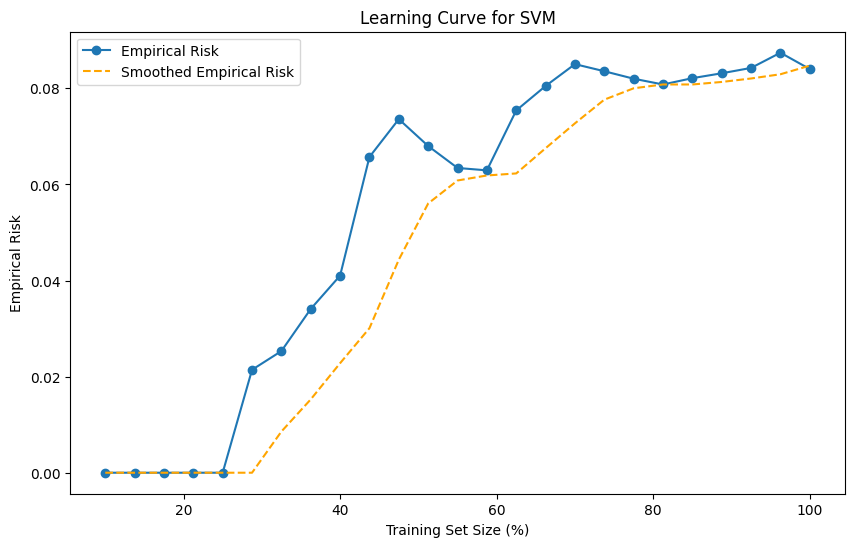

In [41]:
ridge = LinearRidgeClassification(tau=0.11600209048258925)
plot_learning_curve(ridge, X_train, Y_train, smoothing_alpha=0.4)

### Линейная классификация с градиентным спуском

100%|██████████| 25/25 [01:55<00:00,  4.64s/it]


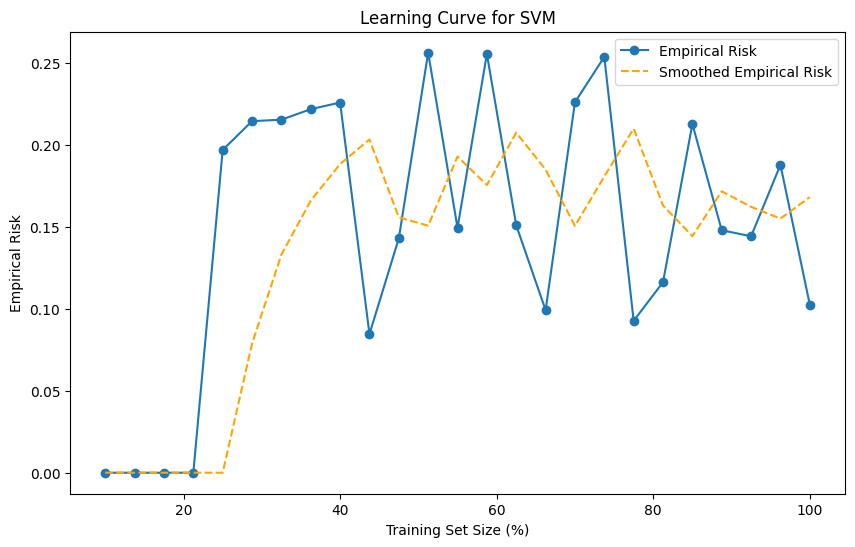

In [39]:
grad = ClassificationWithGradientDescent(rate=0.6853175973558658,
                                        alpha=1.975148553115309,
                                        l1_ratio=0.8412838236305573,
                                        loss_func='exponential',
                                        batch_size=14,
                                        num_epochs=1000,
                                        tolerance=1e-06,
                                        random_state=10
                                        )
plot_learning_curve(grad, X_train, Y_train, smoothing_alpha=0.4)

### Метод опорных векторов через SMO

100%|██████████| 25/25 [00:00<00:00, 49.97it/s] 


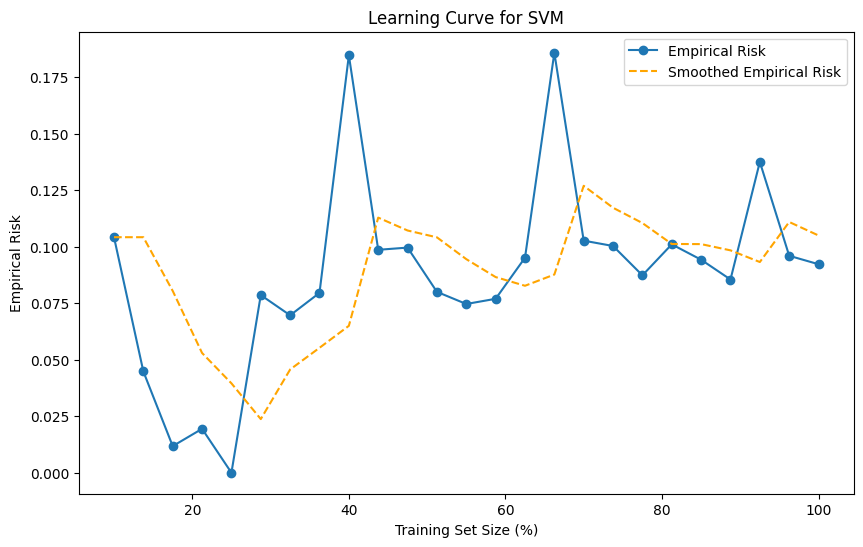

In [40]:
svm = SVM(kernel='quadratic', C=6.663375022041529, num_epochs=1000, tolerance=1e-06)
plot_learning_curve(svm, X_train, Y_train, smoothing_alpha=0.4)

## Кривая обучения на тестовом множестве

In [77]:
def equality_function(y_test, y_pred):
    return accuracy_score(y_test, y_pred)


def learning_curve_test(model, X, Y, num_trials=10):
    test_sizes = np.linspace(0.1, 0.5, 10)
    mean_scores = []
    confidence_intervals = []

    for test_size in tqdm(test_sizes):
        scores = []

        for i in range(num_trials):
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=None,
                                                                stratify=df['Инверторный компрессор'])

            model.fit(x_train.to_numpy(), y_train.to_numpy())
            y_pred = model.predict(x_test.to_numpy())
            score = equality_function(y_test.to_numpy(), np.array(y_pred))
            scores.append(score)

        mean_score = np.mean(scores)
        std_error = np.std(scores) / np.sqrt(num_trials)
        confidence_interval = 1.96 * std_error

        mean_scores.append(mean_score)
        confidence_intervals.append(confidence_interval)

    return mean_scores, confidence_interval

def plot_lc(mean_scores, confidence_intervals):
    test_sizes = np.linspace(0.1, 0.5, 10)
    plt.figure(figsize=(10, 6))
    plt.plot((1 - test_sizes) * 100, mean_scores, marker='o', label='Mean Accuracy')
    plt.fill_between((1 - test_sizes) * 100,
                      np.array(mean_scores) - np.array(confidence_intervals),
                      np.array(mean_scores) + np.array(confidence_intervals),
                      color='green', alpha=0.2, label='95% Confidence Interval')

    plt.xlabel("Training Set Size (%)")
    plt.ylabel("Accuracy score")
    plt.title("Learning Curve for test set")
    plt.legend()
    plt.show()

### Линейная регрессия с гребневой *регуляризацией*

100%|██████████| 10/10 [00:00<00:00, 24.83it/s]


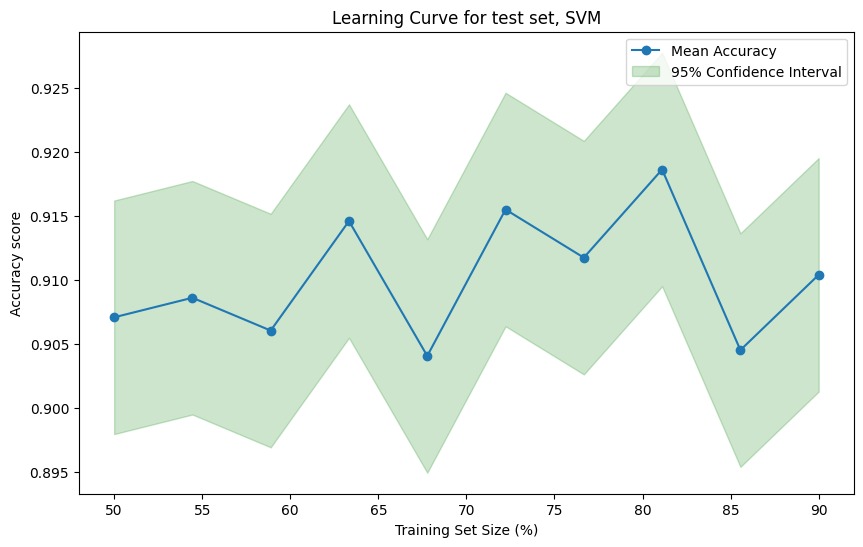

In [80]:
ridge = LinearRidgeClassification(tau=0.11600209048258925)

mean_scores_ridge, confidence_intervals_ridge = learning_curve_test(ridge, X, Y)

plot_lc(mean_scores_ridge, confidence_intervals_ridge)

### Линейная классификация с градиентным спуском

100%|██████████| 10/10 [14:25<00:00, 86.52s/it]


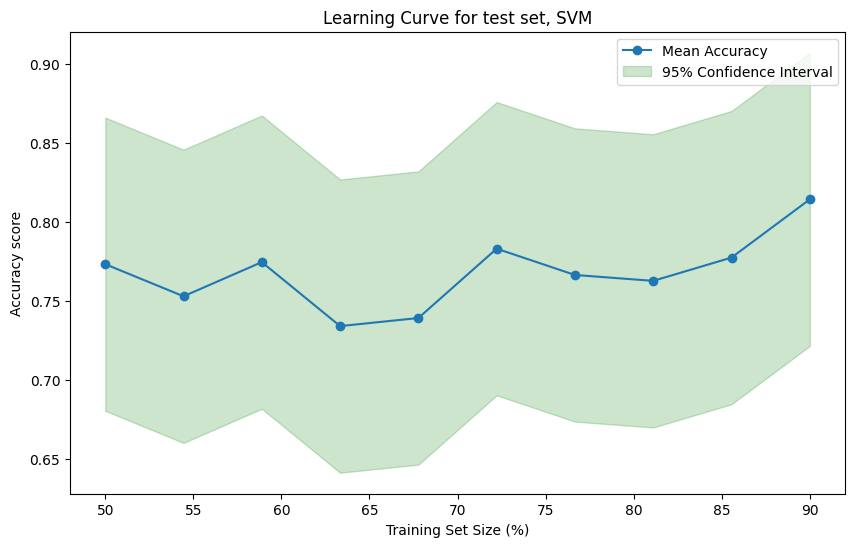

In [84]:
grad = ClassificationWithGradientDescent(rate=0.6853175973558658,
                                        alpha=1.975148553115309,
                                        l1_ratio=0.8412838236305573,
                                        loss_func='exponential',
                                        batch_size=14,
                                        num_epochs=1000,
                                        tolerance=1e-06,
                                        random_state=10
                                        )

mean_scores_grad, confidence_intervals_grad = learning_curve_test(grad, X, Y)

plot_lc(mean_scores_grad, confidence_intervals_grad)

### Метод опорных векторов через SMO

100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


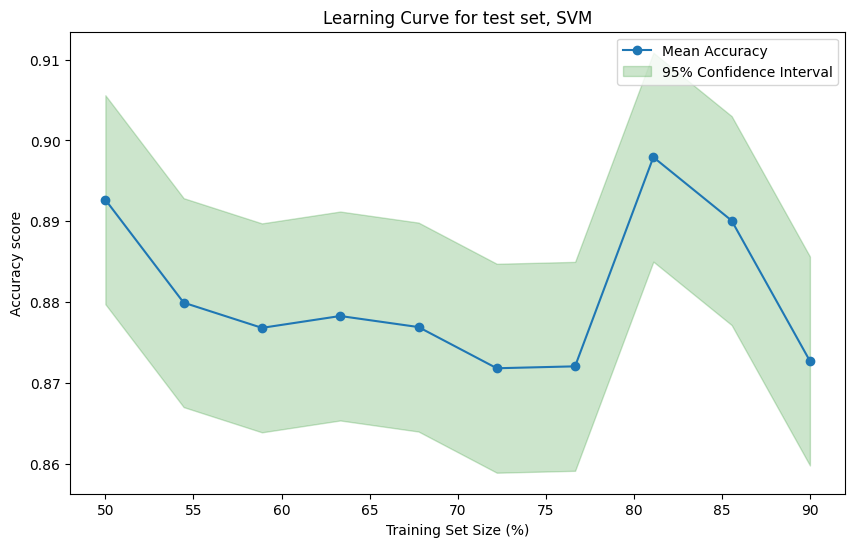

In [83]:
svm = SVM(kernel='quadratic', C=6.663375022041529, num_epochs=1000, tolerance=1e-06)

mean_scores_svm, confidence_intervals_svm = learning_curve_test(svm, X, Y)

plot_lc(mean_scores_svm, confidence_intervals_svm)

## С добавленной прямой линейной регрессии

In [87]:
X_train = pd.concat([X_train, X_val], ignore_index=True)
Y_train = pd.concat([Y_train, Y_val], ignore_index=True)

regr = LinearRidgeClassification(0.4)
regr.fit(X_train.to_numpy(), Y_train.to_numpy())

y_pred = regr.predict(X_test)

accuracy = accuracy_score(Y_test.to_numpy(), y_pred)

### Линейная классификация с градиентным спуском

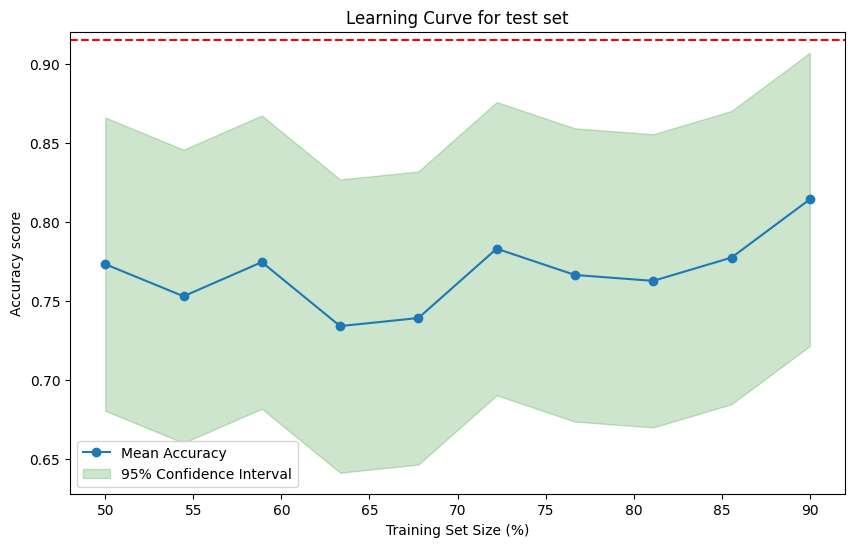

In [88]:
test_sizes = np.linspace(0.1, 0.5, 10)
plt.figure(figsize=(10, 6))
plt.plot((1 - test_sizes) * 100, mean_scores_grad, marker='o', label='Mean Accuracy')
plt.fill_between((1 - test_sizes) * 100,
                  np.array(mean_scores_grad) - np.array(confidence_intervals_grad),
                  np.array(mean_scores_grad) + np.array(confidence_intervals_grad),
                  color='green', alpha=0.2, label='95% Confidence Interval')
plt.axhline(y=accuracy, color='red', linestyle='--')

plt.xlabel("Training Set Size (%)")
plt.ylabel("Accuracy score")
plt.title("Learning Curve for test set")
plt.legend()
plt.show()

### Метод опорных векторов через SMO

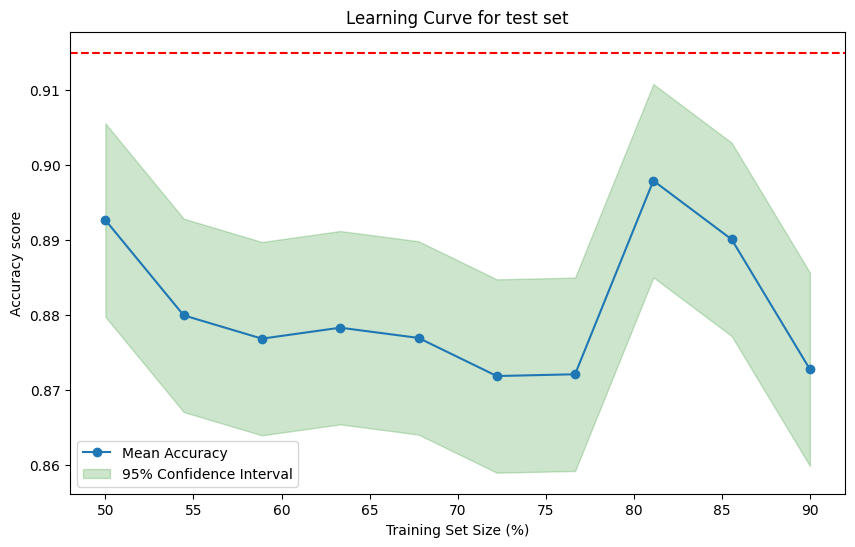

In [89]:
test_sizes = np.linspace(0.1, 0.5, 10)
plt.figure(figsize=(10, 6))
plt.plot((1 - test_sizes) * 100, mean_scores_svm, marker='o', label='Mean Accuracy')
plt.fill_between((1 - test_sizes) * 100,
                  np.array(mean_scores_svm) - np.array(confidence_intervals_svm),
                  np.array(mean_scores_svm) + np.array(confidence_intervals_svm),
                  color='green', alpha=0.2, label='95% Confidence Interval')
plt.axhline(y=accuracy, color='red', linestyle='--')

plt.xlabel("Training Set Size (%)")
plt.ylabel("Accuracy score")
plt.title("Learning Curve for test set")
plt.legend()
plt.show()